## GLIE MC Control Algorithm

- GLIE $\; \rightarrow \;$ Greedy in the Limit with Infinite Exploration
- MC $\; \rightarrow \;$ Monte Carlo

This is an on-policy algorithm.

Resources used while writing this notebook:
- [Nimish Sanghi's book on Deep RL](https://www.amazon.com/Deep-Reinforcement-Learning-Python-TensorFlow/dp/1484268083)
- Tawsif Kamal's videos on Blackjack Monte Carlo Reinforcement Learning [part 1](https://youtu.be/NeusGkowXR4?si=9a1aE_bInK4vSAHw) and [part 2](https://youtu.be/wn8hlPNwL74?si=PV_h3WQCXmZKwRzW).
- [Gymnasium docs for Blackjack](https://gymnasium.farama.org/environments/toy_text/blackjack/).

![Exploring Starts](./algo_img/mc_control.png "Exploring Starts")

![Epsilon-Soft](./algo_img/mc_control_epsilon_soft.png "Epsilon-Soft")

In [2]:
from IPython.display import Image
Image(url="https://gymnasium.farama.org/_images/blackjack.gif")

In [5]:
import gymnasium as gym
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
from blackjack.plot_utils import plot_policy, plot_win_rate

# create Blackjack environment
env = gym.make("Blackjack-v1", natural=False, sab=False)

In [57]:
def epsilon_soft_strategy(env, Q, state, epsilon):
    probs = np.zeros(2)
    # since there are only two actions: 0 and 1
    # so, optimal action is either 0 or 1
    # and, sub-optimal action is the other one 
    optimal_action = np.argmax(Q[state])
    sub_optimal_action = np.abs(optimal_action - 1)
    probs[optimal_action] = 1 - epsilon + epsilon/env.action_space.n
    probs[sub_optimal_action] = epsilon/env.action_space.n
    action = np.random.choice([0,1], p=probs)
    return action


In [8]:
def epsilon_greedy_strategy(env, epsilon, policy, state):
    if np.random.random() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(policy[state])
    

In [31]:
class GLIE_MC_Control:
    def __init__(self, env, num_episodes, epsilon, strategy, policy, 
                 gamma=1, epsilon_min=None, decay_rate=None, alpha=None):
        """
        param env: (gymnasium environment) the environment to run the algorithm on
        param num_episodes: (int) number of episodes to run the algorithm
        param epsilon: (float) 
        param epsilon_min: float or None
        param decay_rate: float or None
        param gamma: (float) discount factor
        param alpha: float or None
        """
        self.env = env
        self.num_episodes = num_episodes
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.decay_rate = decay_rate
        self.gamma = gamma
        n_actions = self.env.action_space.n
        self.Q = defaultdict(lambda: np.zeros(n_actions))  # state-action value
        self.N = defaultdict(lambda: np.zeros(n_actions))  # visit count
        self.policy = policy
        self.gamma = gamma                      # discount factor
        self.epsilon = epsilon                  # exploration rate
        self.strategy = strategy                # action selection strategy
        self.alpha = alpha                      # constant factor
        self.rewards_all_episodes_fv = []
        self.rewards_all_episodes_ev = []
    

    def generate_episode(self):
        state, _ = self.env.reset()
        episode = []
        while True:
            action = self.strategy(self.env, self.epsilon, 
                                   self.policy, state)
            next_state, reward, done, trunc, _ = self.env.step(action)
            episode.append((state, action, reward))
            state = next_state
            if (done or trunc):
                break
        return episode


    def first_visit(self):
        """
        This is the first-visit GLIE MC control algorithm.
        """
        for k in tqdm(range(1, self.num_episodes+1)):
            experience = self.generate_episode()
            states, actions, rewards = zip(*experience)
            self.rewards_all_episodes_fv.append(sum(rewards))
            G = 0
            for t in range(len(states)-1, -1, -1):
                s, a, r = states[t], actions[t], rewards[t]
                G = self.gamma * G + r
                if s not in states[:t]:
                    if self.alpha is not None:
                        self.Q[s][a] = self.Q[s][a] + self.alpha * (G - self.Q[s][a])
                    else:
                        self.N[s][a] += 1
                        self.Q[s][a] = self.Q[s][a] + (1 / self.N[s][a]) * (G - self.Q[s][a])
                    # update the policy
                    for state_value, q_value in self.Q.items():
                        self.policy[state_value] = np.argmax(q_value)
            # update epsilon
            if (self.decay_rate is not None) and (self.epsilon_min is not None):
                self.epsilon = max(self.epsilon_min, self.epsilon * self.decay_rate)
            else:
                self.epsilon = 1/k
                

    def every_visit(self):
        """
        This is the every-visit GLIE MC control algorithm.
        """
        for k in tqdm(range(1, self.num_episodes+1)):
            experience = self.generate_episode()
            states, actions, rewards = zip(*experience)
            self.rewards_all_episodes_ev.append(sum(rewards))
            G = 0
            for t in range(len(states)-1, -1, -1):
                s, a, r = states[t], actions[t], rewards[t]
                G = self.gamma * G + r
                if self.alpha is not None:
                    self.Q[s][a] = self.Q[s][a] + self.alpha * (G - self.Q[s][a])
                else:
                    self.N[s][a] += 1
                    self.Q[s][a] = self.Q[s][a] + (1 / self.N[s][a]) * (G - self.Q[s][a])
                # update the policy
                for state_value, q_value in self.Q.items():
                    self.policy[state_value] = np.argmax(q_value)
            # update epsilon
            if (self.decay_rate is not None) and (self.epsilon_min is not None):
                self.epsilon = max(self.epsilon_min, self.epsilon * self.decay_rate)
            else:
                self.epsilon = 1/k
            # uncomment this to have higher exploration initially
            # and then let epsilon decay after 5000 episodes
            # if k <= 100:
            #     self.epsilon = 0.02

In [45]:
env = gym.make("Blackjack-v1", natural=False, sab=False)
n_actions = env.action_space.n
random_policy = defaultdict(lambda: np.ones(n_actions) / n_actions)
num_episodes = 50_000
gamma = 1
epsilon = 1
strategy = epsilon_greedy_strategy

In [46]:
fv_glie = GLIE_MC_Control(env, num_episodes, epsilon, strategy, random_policy)

In [47]:
fv_glie.generate_episode()

[((19, 9, 0), 0, -1.0)]

In [48]:
fv_glie.first_visit()

100%|██████████| 50000/50000 [00:42<00:00, 1182.13it/s]


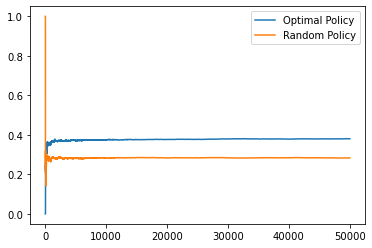

In [49]:
plot_win_rate(fv_glie.rewards_all_episodes_fv, fv_glie.num_episodes)

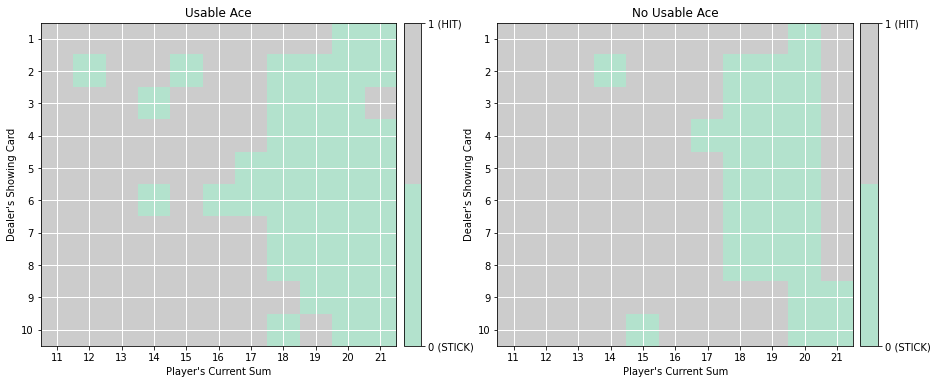

In [50]:
# the plots are empty as we don't have a policy, ie,
# we are following a random policy
plot_policy(fv_glie.policy)

In [51]:
env = gym.make("Blackjack-v1", natural=False, sab=False)
n_actions = env.action_space.n
random_policy = defaultdict(lambda: np.ones(n_actions) / n_actions)
num_episodes = 50_000
gamma = 1
epsilon = 1
strategy = epsilon_greedy_strategy
epsilon_min = 0.05
alpha = 0.03
decay_rate = 0.9999

In [52]:
fv_glie2 = GLIE_MC_Control(env, num_episodes, epsilon, strategy, random_policy,
                           gamma, epsilon_min, decay_rate, alpha)

In [53]:
fv_glie2.generate_episode()

[((9, 6, 0), 0, -1.0)]

In [54]:
fv_glie2.first_visit()

  0%|          | 128/50000 [00:00<00:39, 1276.56it/s]

100%|██████████| 50000/50000 [00:39<00:00, 1253.99it/s]


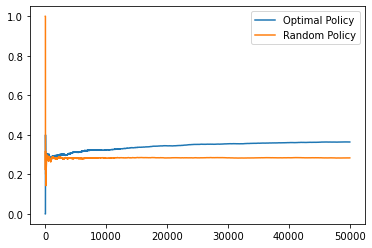

In [55]:
plot_win_rate(fv_glie2.rewards_all_episodes_fv, fv_glie2.num_episodes)

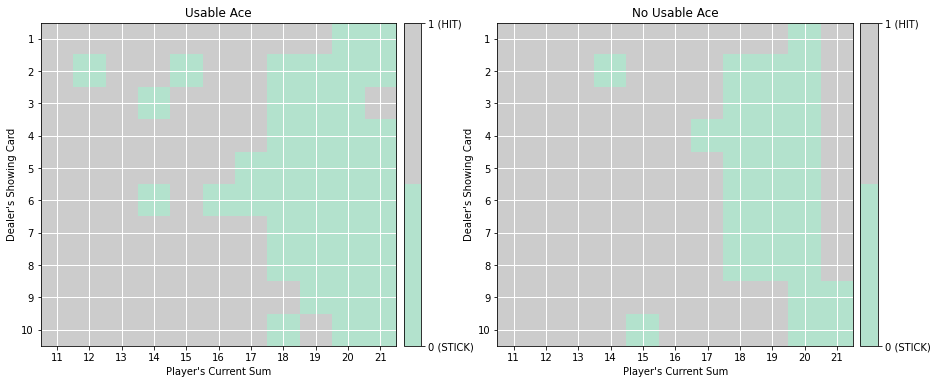

In [56]:
# the plots are empty as we don't have a policy, ie,
# we are following a random policy
plot_policy(fv_glie.policy)

![Optimal Policy](./blackjack/optimal.png "Optimal Policy")

In [32]:
env = gym.make("Blackjack-v1", natural=False, sab=False)
n_actions = env.action_space.n
random_policy = defaultdict(lambda: np.ones(n_actions) / n_actions)
num_episodes = 10_000
gamma = 1
epsilon = 1
strategy = epsilon_greedy_strategy

In [33]:
ev_glie = GLIE_MC_Control(env, num_episodes, epsilon, strategy, random_policy)

In [34]:
ev_glie.generate_episode()

[((7, 10, 0), 0, -1.0)]

In [35]:
ev_glie.every_visit()

100%|██████████| 10000/10000 [00:08<00:00, 1245.56it/s]


Exception ignored in: <function tqdm.__del__ at 0x7f9c27607670>
Traceback (most recent call last):
  File "/home/aryaman/anaconda3/lib/python3.9/site-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/home/aryaman/anaconda3/lib/python3.9/site-packages/tqdm/std.py", line 1291, in close
    if self.last_print_t < self.start_t + self.delay:
AttributeError: 'tqdm' object has no attribute 'last_print_t'


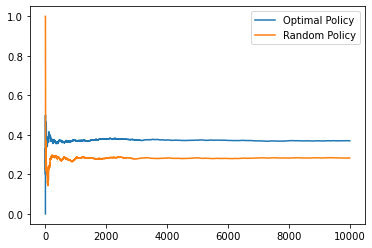

In [38]:
plot_win_rate(ev_glie.rewards_all_episodes_ev, ev_glie.num_episodes)

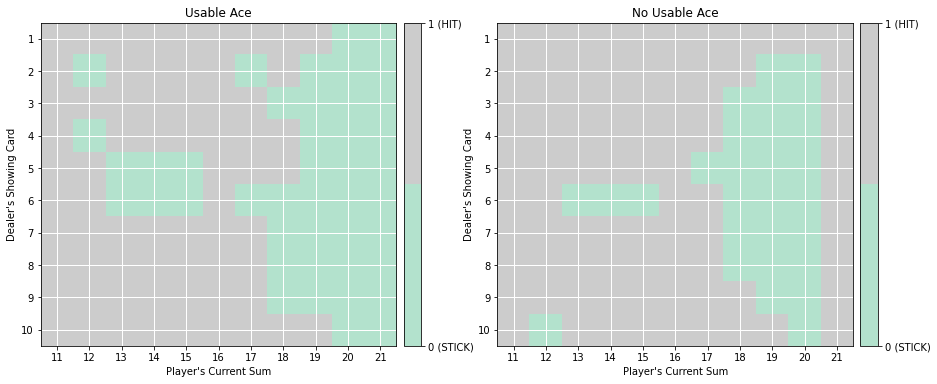

In [39]:
# the plots are empty as we don't have a policy, ie,
# we are following a random policy
plot_policy(ev_glie.policy)